In [1]:
!pip install pycaret

In [36]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
import warnings
import logging
import random
import lightgbm as lgb
import requests
import sys
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, make_scorer, recall_score, precision_score
from sklearn.feature_selection import RFE
from hyperopt import fmin, tpe, hp, Trials
from hyperopt.pyll.base import scope
from pycaret.datasets import get_data
from pycaret.classification import setup, compare_models, predict_model
warnings.filterwarnings('ignore', category=UserWarning)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params={'id': id}, stream=True)
    token = get_confirm_token(response)

    if token:
        params = {'id': id, 'confirm': token}
        response = session.get(URL, params=params, stream=True)

    save_response_content(response, destination)

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk:  # filter out keep-alive new chunks
                f.write(chunk)

file_id = '1EW-XMnGfxn-qzGtGPa3v_C63Yqj2aGf7'
destination = 'term-deposit-marketing-2020.csv'
download_file_from_google_drive(file_id, destination)
df=pd.read_csv(destination)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


# Data Analysis

In [5]:
# check for missing values
df.isnull().sum()

,0
age,0
job,0
marital,0
education,0
default,0
balance,0
housing,0
loan,0
contact,0
day,0


In [6]:
# check data types
df.dtypes

,0
age,int64
job,object
marital,object
education,object
default,object
balance,int64
housing,object
loan,object
contact,object
day,int64


In [7]:
print(df.describe())
print(df.describe(include=['object']))

                age        balance           day      duration      campaign
count  40000.000000   40000.000000  40000.000000  40000.000000  40000.000000
mean      40.544600    1274.277550     16.017225    254.824300      2.882175
std        9.641776    2903.769716      8.278127    259.366498      3.239051
min       19.000000   -8019.000000      1.000000      0.000000      1.000000
25%       33.000000      54.000000      8.000000    100.000000      1.000000
50%       39.000000     407.000000     17.000000    175.000000      2.000000
75%       48.000000    1319.000000     21.000000    313.000000      3.000000
max       95.000000  102127.000000     31.000000   4918.000000     63.000000
                job  marital  education default housing   loan   contact  \
count         40000    40000      40000   40000   40000  40000     40000   
unique           12        3          4       2       2      2         3   
top     blue-collar  married  secondary      no     yes     no  cellular   
fre

In [8]:
df.dtypes

,0
age,int64
job,object
marital,object
education,object
default,object
balance,int64
housing,object
loan,object
contact,object
day,int64


In [9]:
for column in df.columns:
    unique_values = df[column].value_counts()
    print(f"Value counts in column '{column}':")
    print(unique_values)
    print("\n")

Value counts in column 'age':
age
32    1909
31    1826
33    1770
34    1730
35    1721
      ... 
90       1
94       1
86       1
95       1
81       1
Name: count, Length: 70, dtype: int64


Value counts in column 'job':
job
blue-collar      9383
management       8166
technician       6852
admin            4483
services         3910
retired          1437
self-employed    1414
entrepreneur     1405
unemployed       1104
housemaid        1087
student           524
unknown           235
Name: count, dtype: int64


Value counts in column 'marital':
marital
married     24386
single      10889
divorced     4725
Name: count, dtype: int64


Value counts in column 'education':
education
secondary    20993
tertiary     11206
primary       6270
unknown       1531
Name: count, dtype: int64


Value counts in column 'default':
default
no     39191
yes      809
Name: count, dtype: int64


Value counts in column 'balance':
balance
 0         3209
 1          179
 2          141
 4          126
 3 

# Phase 1:  Determine customers that are more like to buy the investment product.

## Data Wrangling

In [10]:
# replace yes, no with 1 and 0
df.replace(['no', 'yes'], [0,1], inplace=True)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,261,1,0
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,151,1,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,76,1,0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,92,1,0
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,198,1,0


In [11]:
# create a month number column
month_map = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
             'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}

# Apply the mapping to the 'month' column
df['month_number'] = df['month'].map(month_map)
# Remove month column
df.drop('month', axis=1, inplace=True)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,duration,campaign,y,month_number
0,58,management,married,tertiary,0,2143,1,0,unknown,5,261,1,0,5
1,44,technician,single,secondary,0,29,1,0,unknown,5,151,1,0,5
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,76,1,0,5
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,92,1,0,5
4,33,unknown,single,unknown,0,1,0,0,unknown,5,198,1,0,5


In [12]:
#split data between target 'Y' and variables 'X'
X = df.drop('y',axis=1)
Y = df['y']
print(Y)
print(X.head())

0        0
1        0
2        0
3        0
4        0
        ..
39995    0
39996    1
39997    1
39998    0
39999    0
Name: y, Length: 40000, dtype: int64
   age           job  marital  education  default  balance  housing  loan  \
0   58    management  married   tertiary        0     2143        1     0   
1   44    technician   single  secondary        0       29        1     0   
2   33  entrepreneur  married  secondary        0        2        1     1   
3   47   blue-collar  married    unknown        0     1506        1     0   
4   33       unknown   single    unknown        0        1        0     0   

   contact  day  duration  campaign  month_number  
0  unknown    5       261         1             5  
1  unknown    5       151         1             5  
2  unknown    5        76         1             5  
3  unknown    5        92         1             5  
4  unknown    5       198         1             5  


In [13]:
# Split data out customer related data
X_customer_cols = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan']
X_customer = X[X_customer_cols]
X_customer.head()

,age,job,marital,education,default,balance,housing,loan
0,58,management,married,tertiary,0,2143,1,0
1,44,technician,single,secondary,0,29,1,0
2,33,entrepreneur,married,secondary,0,2,1,1
3,47,blue-collar,married,unknown,0,1506,1,0
4,33,unknown,single,unknown,0,1,0,0


## Data Visualization

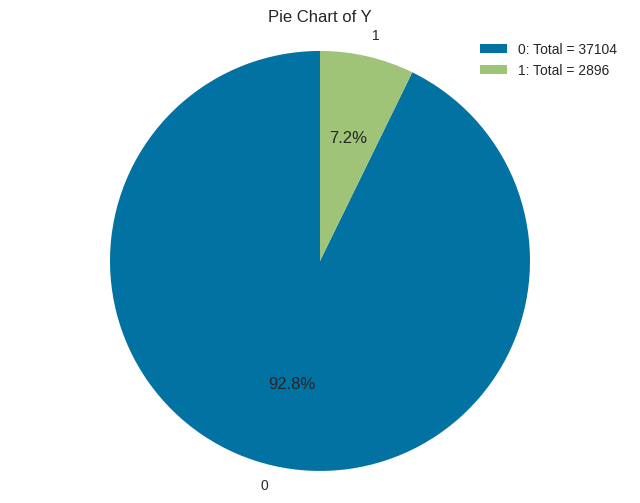

In [14]:
# Replace this with your actual data and labels
y_counts = df['y'].value_counts()
labels = y_counts.index
sizes = y_counts.values


plt.figure(figsize=(8, 6))  # Adjust figure size as needed
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)  # Use autopct for percentage display
plt.title('Pie Chart of Y')

# Add a legend with total values
total = sum(sizes)
legend_labels = [f'{label}: Total = {size}' for label, size in zip(labels,sizes)]
plt.legend(legend_labels, loc="best")


plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


### Subscription status by categorical features

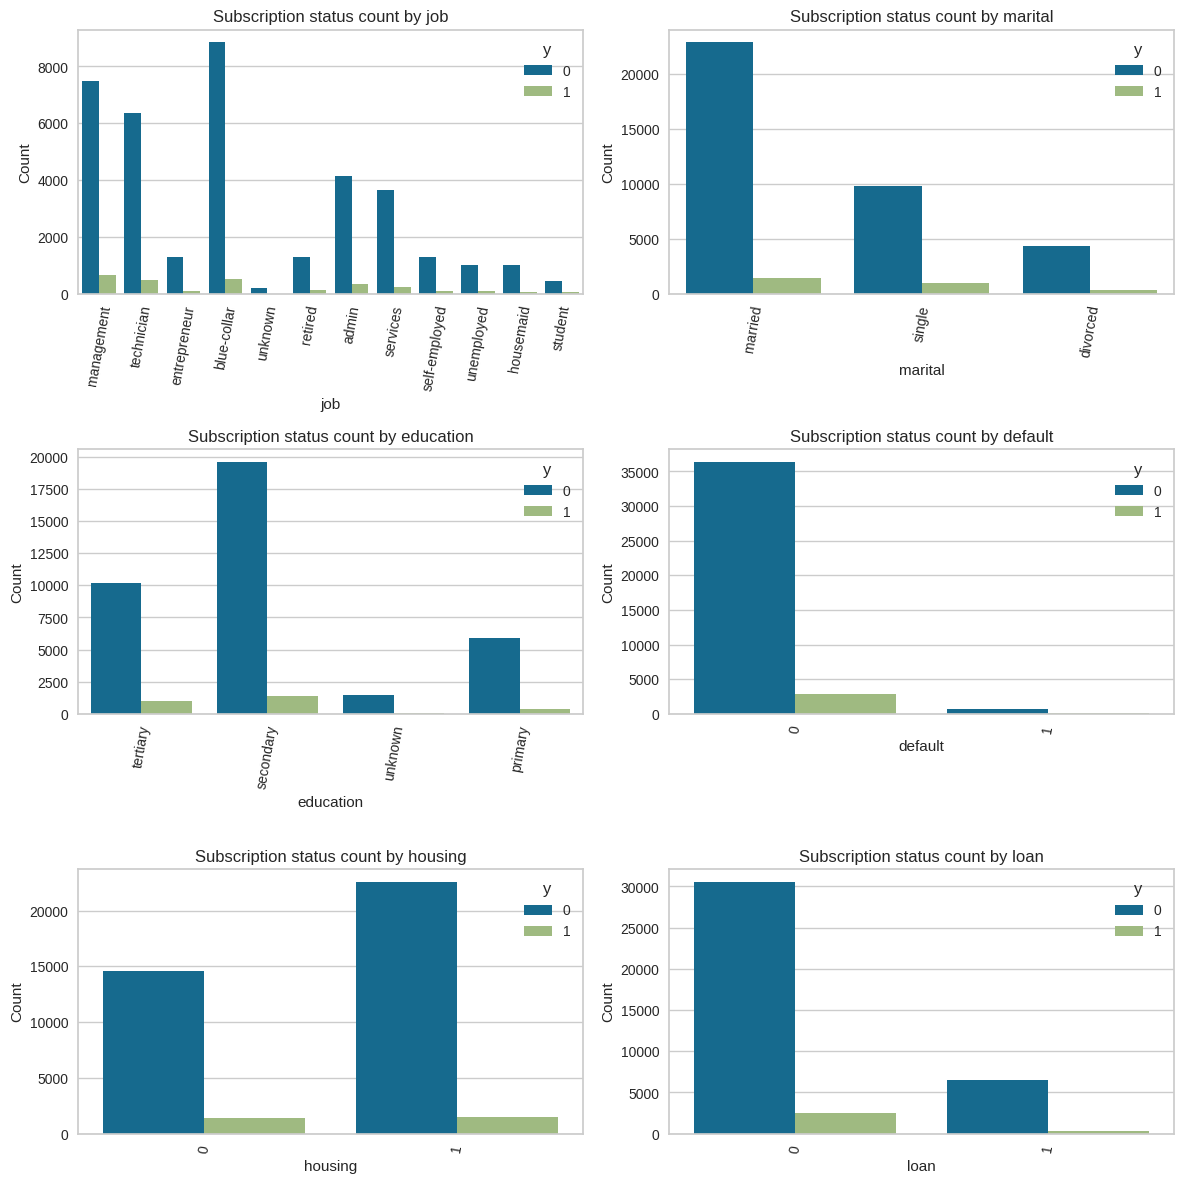

In [15]:
plt.figure(figsize=(12, 20))
for i, col in enumerate(['job', 'marital', 'education', 'default', 'housing', 'loan']):
    plt.subplot(5, 2, i + 1)
    sns.countplot(data=df, x=col, hue='y')
    plt.title(f'Subscription status count by {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=80)
plt.tight_layout()
plt.show()

### Subscription status by continous features

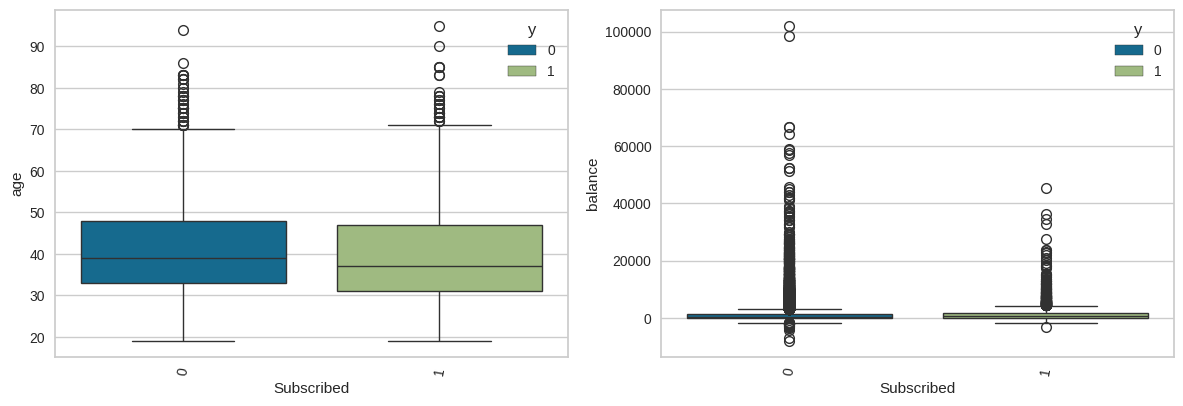

In [16]:
plt.figure(figsize=(12, 20))
for i, col in enumerate(['age', 'balance']):
    plt.subplot(5, 2, i + 1)
    sns.boxplot(y=col, x='y', data=df, hue='y')
    plt.xlabel('Subscribed')
    plt.ylabel(col)
    plt.xticks(rotation=80)
plt.tight_layout()
plt.show()

## Predictive Analysis

### Data preprocessing

In [17]:
# convert categorical columns with one hot encoding
X_customer = pd.get_dummies(data=X_customer, columns=(['job', 'marital', 'education']), drop_first=True)
X_customer.head()

,age,default,balance,housing,loan,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,...,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown
0,58,0,2143,1,0,False,False,False,True,False,...,False,False,False,False,False,True,False,False,True,False
1,44,0,29,1,0,False,False,False,False,False,...,False,False,True,False,False,False,True,True,False,False
2,33,0,2,1,1,False,True,False,False,False,...,False,False,False,False,False,True,False,True,False,False
3,47,0,1506,1,0,True,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
4,33,0,1,0,0,False,False,False,False,False,...,False,False,False,False,True,False,True,False,False,True


In [18]:
# scaling of continous features
continous_cols = ['age', 'balance']
transform = preprocessing.StandardScaler()
X_customer[continous_cols] = transform.fit_transform(X_customer[continous_cols])
X_customer.head()

,age,default,balance,housing,loan,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,...,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown
0,1.810415,0,0.299174,1,0,False,False,False,True,False,...,False,False,False,False,False,True,False,False,True,False
1,0.358382,0,-0.428854,1,0,False,False,False,False,False,...,False,False,True,False,False,False,True,True,False,False
2,-0.782501,0,-0.438152,1,1,False,True,False,False,False,...,False,False,False,False,False,True,False,True,False,False
3,0.669532,0,0.079802,1,0,True,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
4,-0.782501,0,-0.438497,0,0,False,False,False,False,False,...,False,False,False,False,True,False,True,False,False,True


In [19]:
# convert binary values to float type
X_customer = X_customer.astype(float)
X_customer.head()

,age,default,balance,housing,loan,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,...,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown
0,1.810415,0.0,0.299174,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.358382,0.0,-0.428854,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,-0.782501,0.0,-0.438152,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.669532,0.0,0.079802,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,-0.782501,0.0,-0.438497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [20]:
Y = Y.astype(float)
Y

,y
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
39995,0.0
39996,1.0
39997,1.0
39998,0.0


In [21]:
seed = random.randint(1000,9999)
### good seeds
#seed = ????
print(seed)

3512


In [22]:
# Split data in test and training sets
X_train, X_test, y_train, y_test = train_test_split(X_customer,Y, test_size=0.2, random_state=seed)

In [23]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(32000, 21)
(32000,)
(8000, 21)
(8000,)


In [24]:
# Initialize PyCaret
clf = setup(data = pd.concat([X_train, pd.DataFrame(y_train, columns=['y'])], axis=1), target = 'y', fold = 5, session_id=seed)

# Compare models
best_model = compare_models(sort='Precision')

# Evaluate the best model on the test set (optional)
predict_model(best_model, data=pd.concat([X_test, pd.DataFrame(y_test, columns=['y'])], axis=1));


,Description,Value
0,Session id,3512
1,Target,y
2,Target type,Binary
3,Original data shape,"(32000, 22)"
4,Transformed data shape,"(32000, 22)"
5,Transformed train set shape,"(22400, 22)"
6,Transformed test set shape,"(9600, 22)"
7,Numeric features,21
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9276,0.5910,0.0099,0.4052,0.0193,0.0160,0.0540,0.4760
gbc,Gradient Boosting Classifier,0.9273,0.6112,0.0105,0.3859,0.0204,0.0164,0.0524,1.4540
ada,Ada Boost Classifier,0.9272,0.6096,0.0080,0.3617,0.0156,0.0121,0.0421,0.5380
xgboost,Extreme Gradient Boosting,0.9267,0.5673,0.0149,0.3069,0.0283,0.0222,0.0540,0.2800
rf,Random Forest Classifier,0.9168,0.5695,0.0508,0.1989,0.0808,0.0530,0.0671,1.8240
knn,K Neighbors Classifier,0.9234,0.5475,0.0167,0.1809,0.0306,0.0183,0.0340,2.4060
et,Extra Trees Classifier,0.8965,0.5529,0.0848,0.1407,0.1058,0.0544,0.0564,1.8700
dt,Decision Tree Classifier,0.8634,0.5201,0.1214,0.1061,0.1131,0.0396,0.0397,0.2160
nb,Naive Bayes,0.8692,0.5733,0.1046,0.1029,0.1031,0.0330,0.0331,0.2200
qda,Quadratic Discriminant Analysis,0.8694,0.5737,0.1040,0.1027,0.1029,0.0328,0.0329,0.1300


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9256,0.6054,0.0068,0.2857,0.0133,0.0099,0.0340


## Optimize and evaluate 3 models

In [25]:
# define a confusion matrix plotter
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(['not subsribed', 'subscribed']); ax.yaxis.set_ticklabels(['not subsribed', 'subscribed'])
    plt.show()

## LightGBM model

In [26]:
# code to suppress lightGBM when running Lazy Classifer
class CustomLogger:
    def __init__(self):
        self.logger = logging.getLogger('lightgbm_custom')
        self.logger.setLevel(logging.ERROR)

    def info(self, message):
        self.logger.info(message)

    def warning(self, message):
        pass# Suppress warnings by not doing anything pass

    def error(self, message):
        self.logger.error(message)
# Register the custom logger
lgb.register_logger(CustomLogger())

In [27]:
# optimize lgbm using hyperopt
# Create a custom logger to suppress warnings
#logger = logging.getLogger('lightgbm')
#logger.setLevel(logging.ERROR)  # Set the desired logging level

def objective_lgbm(params):
    # Convert parameters to integer if needed
    for parameter_name in ['max_depth', 'num_leaves', 'min_child_samples', 'n_estimators']: # Include 'n_estimators' here
      params[parameter_name] = int(params[parameter_name])

    lgbm = lgb.LGBMClassifier(**params)
    lgbm.fit(X_train, y_train)
    y_pred_lgbm = lgbm.predict(X_test)

    # Use precision as the evaluation metric
    precision = precision_score(y_test, y_pred_lgbm)

    return -precision


search_lgbm = {
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'n_estimators': hp.quniform('n_estimators', 50, 500, 1),
    'max_depth': hp.quniform('max_depth', 3, 12, 1),
    'num_leaves': hp.quniform('num_leaves', 20, 100, 1),
    'min_child_samples': hp.quniform('min_child_samples', 10, 50, 1),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1)
}

trials_lgbm = Trials()
best_lgbm = fmin(fn=objective_lgbm, space=search_lgbm, algo=tpe.suggest, max_evals=100, trials=trials_lgbm)
print("Best hyperparameters:", best_lgbm)


100%|██████████| 100/100 [01:27<00:00,  1.14trial/s, best loss: -0.6666666666666666]
Best hyperparameters: {'colsample_bytree': 0.7514280491273266, 'learning_rate': 0.16833011861574645, 'max_depth': 5.0, 'min_child_samples': 49.0, 'n_estimators': 122.0, 'num_leaves': 55.0, 'reg_alpha': 0.7796477048902279, 'reg_lambda': 0.4457790548923791, 'subsample': 0.8415490861944736}


                precision    recall  f1-score   support

Not Subscribed       0.93      1.00      0.96      7411
    Subscribed       0.67      0.01      0.03       589

      accuracy                           0.93      8000
     macro avg       0.80      0.51      0.49      8000
  weighted avg       0.91      0.93      0.89      8000



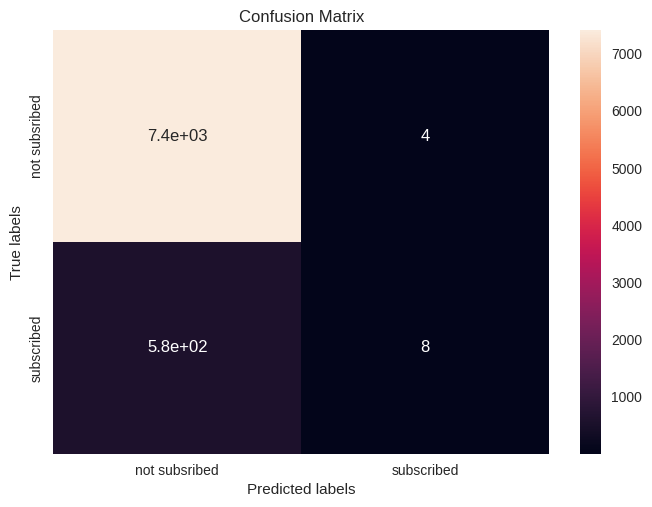

In [28]:

# Train a model with the best hyperparameters
best_params_lgbm = lgb.LGBMClassifier(**best_lgbm)

# Convert parameters to integer if needed
for parameter_name in ['max_depth', 'num_leaves', 'min_child_samples', 'n_estimators']:
    best_lgbm[parameter_name] = int(best_lgbm[parameter_name])
lgbm_best = lgb.LGBMClassifier(**best_lgbm)

lgbm_best.fit(X_train, y_train)
y_pred = lgbm_best.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['Not Subscribed', 'Subscribed'])
report_lgbm = classification_report(y_test, y_pred, target_names=['Not Subscribed', 'Subscribed'], output_dict=True)
precision_lgbm = report_lgbm['Subscribed']['precision']
print(report)
plot_confusion_matrix(y_test,y_pred)

In [33]:
feature_importances = lgbm_best.feature_importances_
importance_df = pd.DataFrame({'Feature': X_customer.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print("\nFeature Importances:")
print(importance_df)


Feature Importances:
                Feature  Importance
2               balance         884
0                   age         782
3               housing         120
16      marital_married          69
13       job_technician          66
18  education_secondary          65
19   education_tertiary          62
5       job_blue-collar          53
17       marital_single          48
8        job_management          46
4                  loan          40
11         job_services          33
7         job_housemaid          24
10    job_self-employed          23
14       job_unemployed          15
20    education_unknown          15
6      job_entrepreneur          14
15          job_unknown          13
1               default          13
9           job_retired          10
12          job_student           3


## Gradient Boosting Classifier

In [38]:
def objective_gbc(params):

    gbc = GradientBoostingClassifier(**params)
    gbc.fit(X_train, y_train)
    y_pred_gbc = gbc.predict(X_test)

    # Use precision as the evaluation metric
    precision = precision_score(y_test, y_pred_gbc)

    return -precision


search_gbc = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 50, 500, 25)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 10, 1)),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 20, 1))
}

trials_gbc = Trials()
best_gbc = fmin(fn=objective_gbc, space=search_gbc, algo=tpe.suggest, max_evals=100, trials=trials_gbc)
print("Best hyperparameters:", best_gbc)

100%|██████████| 100/100 [21:52<00:00, 13.13s/trial, best loss: -1.0]
Best hyperparameters: {'learning_rate': 0.00710037868966469, 'max_depth': 6.0, 'min_samples_split': 7.0, 'n_estimators': 125.0}


                precision    recall  f1-score   support

Not Subscribed       0.93      1.00      0.96      7411
    Subscribed       0.00      0.00      0.00       589

      accuracy                           0.93      8000
     macro avg       0.46      0.50      0.48      8000
  weighted avg       0.86      0.93      0.89      8000



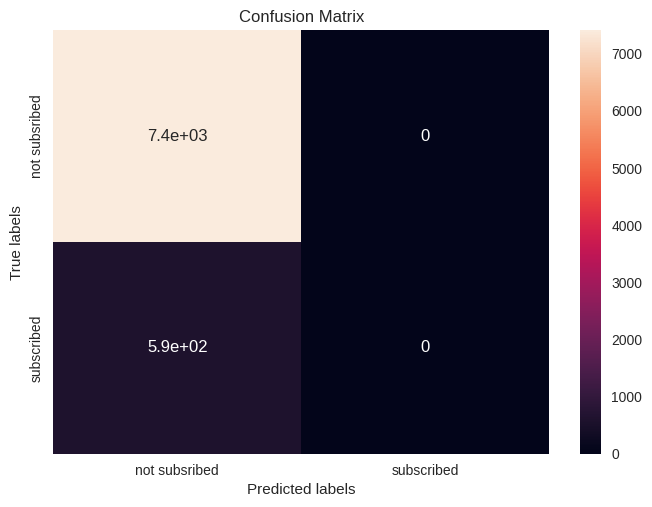

In [42]:
# Train a model with the best hyperparameters
for parameter_name in ['max_depth', 'min_samples_split', 'n_estimators']:
    best_gbc[parameter_name] = int(best_gbc[parameter_name])
best_params_gbc = {
    'n_estimators': best_gbc['n_estimators'],
    'max_depth': best_gbc['max_depth'],
    'learning_rate': best_gbc['learning_rate'],
    'min_samples_split': best_gbc['min_samples_split']
}
gbc_best = GradientBoostingClassifier(**best_params_gbc, random_state=seed)

gbc_best.fit(X_train, y_train)
y_pred = gbc_best.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['Not Subscribed', 'Subscribed'])
report_gbc = classification_report(y_test, y_pred, target_names=['Not Subscribed', 'Subscribed'], output_dict=True)
precision_gbc = report_gbc['Subscribed']['precision']
print(report)
plot_confusion_matrix(y_test,y_pred)

In [43]:
feature_importances = gbc_best.feature_importances_
importance_df = pd.DataFrame({'Feature': X_customer.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print("\nFeature Importances:")
print(importance_df)


Feature Importances:
                Feature    Importance
0                   age  4.063480e-01
2               balance  2.644937e-01
3               housing  1.099788e-01
19   education_tertiary  6.149900e-02
17       marital_single  5.588505e-02
16      marital_married  4.773847e-02
4                  loan  1.716544e-02
5       job_blue-collar  6.847148e-03
18  education_secondary  6.334550e-03
8        job_management  6.161562e-03
20    education_unknown  4.808115e-03
12          job_student  3.720701e-03
14       job_unemployed  2.302333e-03
7         job_housemaid  1.956848e-03
9           job_retired  1.505863e-03
10    job_self-employed  1.292376e-03
6      job_entrepreneur  1.210588e-03
1               default  7.513350e-04
13       job_technician  5.633815e-08
11         job_services  0.000000e+00
15          job_unknown  0.000000e+00
